In [5]:
import pandas as pd
import numpy as np

import json
import joblib
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

from ensembles.boosting import GradientBoostingMSE
from ensembles.random_forest import RandomForestMSE
from ensembles.utils import rmsle, get_df_info

import tqdm
import folium
from haversine import haversine, Unit

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import colormaps
from matplotlib.colorbar import ColorbarBase

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.display import display

## Эксперимент 1

In [6]:
data = pd.read_csv('kc_house_data.csv')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [7]:
data['date'] = pd.to_datetime(data['date'])

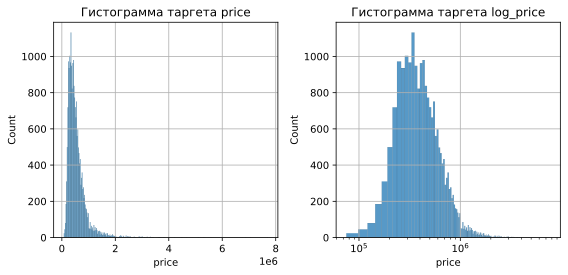

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data, x='price', ax=ax[0])
ax[0].set_title('Гистограмма таргета price')
ax[0].grid()

sns.histplot(data, x='price', ax=ax[1])
ax[1].set_title('Гистограмма таргета log_price')
ax[1].grid()
ax[1].set_xscale('log')

plt.tight_layout()

plt.savefig('hist_target.svg')
plt.show()

In [9]:
def calculate_haversine(row, center=(47.6188, -122.2266)):
    coord = (row['lat'], row['long'])
    return haversine(center, coord, unit=Unit.KILOMETERS)

data['distance_to_сenter'] = data.apply(calculate_haversine, axis=1)

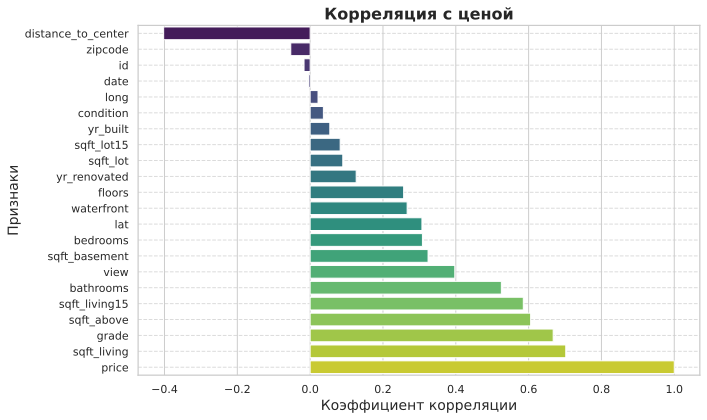

In [10]:
corr = data.corr()['price'].sort_values()

sns.set(style="whitegrid", context="notebook")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=corr.values, y=corr.index, palette="viridis", ax=ax, hue=corr.index)

ax.set_title('Корреляция с ценой', fontsize=16, fontweight='bold')
ax.set_xlabel('Коэффициент корреляции', fontsize=14)
ax.set_ylabel('Признаки', fontsize=14)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('corr.svg')

plt.show()

## Эксперимент 2

In [11]:
# 'id', 'price', 'log_price'
numerical = [
    'sqft_living', 'sqft_lot', 'floors', 'waterfront',
    'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',  
    'lat', 'long', 'sqft_living15', 'sqft_lot15', 'distance_to_сenter'
]
categorical = ['date', 'bedrooms', 'bathrooms', 'yr_built', 'yr_renovated', 'zipcode']

In [12]:
data_train, data_test, y_train, y_test = train_test_split(data[numerical + categorical], data['price'], test_size=0.2, random_state=42)

print(f'Количество объектов в train: {data_train.shape[0]}',
      f'Количество объектов в test : {data_test.shape[0]}', sep='\n')

Количество объектов в train: 17290
Количество объектов в test : 4323


In [13]:
encoder = TargetEncoder(target_type='continuous')
encoder.fit(data_train[categorical], y_train)

X_train = data_train.copy()
X_train[categorical] = encoder.transform(data_train[categorical])

X_test = data_test.copy()
X_test[categorical] = encoder.transform(data_test[categorical])

In [14]:
root_mean_squared_error(np.full(y_test.shape[0], y_test.mean()), y_test)


388814.4959448613

### Количество деревьев в ансамбле

In [15]:
n_estimators_list = [1, 5, 10, 20, 50, 100, 200]

results = pd.DataFrame({
    'n_estimators': [],
    'rmse_test': [],
    'fit_time': []
})

for n_estimators in tqdm.tqdm(n_estimators_list, desc="Training models"):
    model = RandomForestMSE(n_estimators=n_estimators)
    
    start_time = time.time()
    history = model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)

    results.loc[len(results)] = [n_estimators, root_mean_squared_error(y_pred, y_test), fit_time]
results

Training models: 100%|█████████████████████████████████████████████████████| 7/7 [01:31<00:00, 13.05s/it]


,n_estimators,rmse_test,fit_time
0,1.0,221421.680801,0.250012
1,5.0,207914.701375,1.167523
2,10.0,209068.114051,2.313389
3,20.0,208261.632735,4.639807
4,50.0,206172.103646,11.516596
5,100.0,205881.511073,23.253514
6,200.0,206268.518655,47.222879


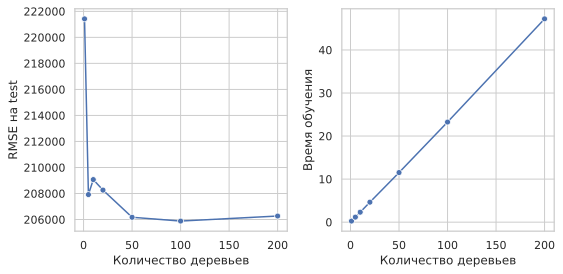

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(data=results, x='n_estimators', y='rmse_test', ax=ax[0], marker='o')
sns.lineplot(data=results, x='n_estimators', y='fit_time', ax=ax[1], marker='o')

ax[0].set_xlabel('Количество деревьев')
ax[1].set_xlabel('Количество деревьев')

ax[0].set_ylabel('RMSE на test')
ax[1].set_ylabel('Время обучения')

plt.tight_layout()

plt.savefig('random_forest n_estimators.svg')
plt.show()

### Размерность подвыборки признаков для одной вершины дерева

In [17]:
n_estimators = 100
max_features_list = np.linspace(0.1, 1, 10)

results1 = pd.DataFrame({
    'max_features': [],
    'rmse_test': [],
    'fit_time': []
})

for max_features in tqdm.tqdm(max_features_list, desc="Training models"):
    model = RandomForestMSE(n_estimators=n_estimators, tree_params={'max_features': max_features})
    
    start_time = time.time()
    history = model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)

    results1.loc[len(results1)] = [max_features, root_mean_squared_error(y_pred, y_test), fit_time]
results1

Training models: 100%|███████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.86s/it]


,max_features,rmse_test,fit_time
0,0.1,145296.154427,3.790228
1,0.2,139449.256870,6.018555
2,0.3,139423.090196,8.178821
3,0.4,141614.047929,10.388570
4,0.5,149229.504065,12.593530
5,0.6,153944.166260,14.557898
6,0.7,158713.762010,16.853897
7,0.8,165804.120467,19.122327
8,0.9,176314.605341,21.301916
9,1.0,206466.292671,23.430667


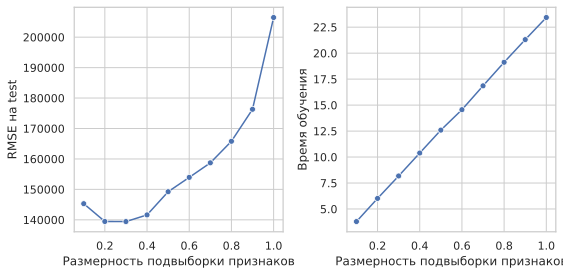

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(data=results1, x='max_features', y='rmse_test', ax=ax[0], marker='o')
sns.lineplot(data=results1, x='max_features', y='fit_time', ax=ax[1], marker='o')

ax[0].set_xlabel('Размерность подвыборки признаков')
ax[1].set_xlabel('Размерность подвыборки признаков')

ax[0].set_ylabel('RMSE на test')
ax[1].set_ylabel('Время обучения')

plt.tight_layout()

plt.savefig('random_forest max_features.svg')
plt.show()

### Максимальная глубина дерева

In [19]:
n_estimators = 100
max_features = 0.2
max_depth_list = [x for x in range(1, 30, 3)] + [None]

results2 = pd.DataFrame({
    'max_depth': [],
    'rmse_test': [],
    'fit_time': []
})

for max_depth in tqdm.tqdm(max_depth_list, desc="Training models"):
    model = RandomForestMSE(n_estimators=n_estimators, tree_params={'max_features': max_features, 'max_depth': max_depth})
    
    start_time = time.time()
    history = model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)

    results2.loc[len(results2)] = [max_depth, root_mean_squared_error(y_pred, y_test), fit_time]
results2

Training models: 100%|███████████████████████████████████████████████████| 11/11 [00:48<00:00,  4.40s/it]


,max_depth,rmse_test,fit_time
0,1.0,312275.165954,0.838102
1,4.0,194566.623653,1.655141
2,7.0,153734.390083,2.455030
3,10.0,142186.159556,3.350273
4,13.0,137889.664920,4.210653
5,16.0,139048.982214,4.831748
6,19.0,140629.700133,5.371700
7,22.0,139295.957043,5.657965
8,25.0,140306.360459,5.920809
9,28.0,139703.533515,5.971683


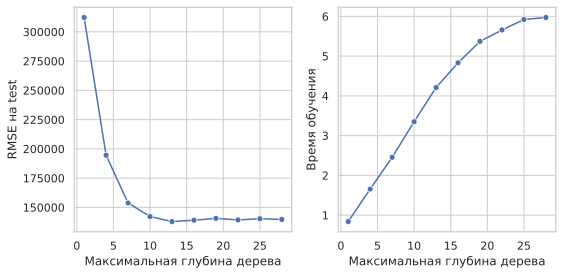

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(data=results2, x='max_depth', y='rmse_test', ax=ax[0], marker='o')
sns.lineplot(data=results2, x='max_depth', y='fit_time', ax=ax[1], marker='o')

ax[0].set_xlabel('Максимальная глубина дерева')
ax[1].set_xlabel('Максимальная глубина дерева')

ax[0].set_ylabel('RMSE на test')
ax[1].set_ylabel('Время обучения')

plt.tight_layout()

plt.savefig('random_forest max_depth.svg')
plt.show()

In [21]:
results2.sort_values(by='rmse_test')

,max_depth,rmse_test,fit_time
4,13.0,137889.664920,4.210653
5,16.0,139048.982214,4.831748
7,22.0,139295.957043,5.657965
9,28.0,139703.533515,5.971683
8,25.0,140306.360459,5.920809
10,NaN,140399.783408,6.012233
6,19.0,140629.700133,5.371700
3,10.0,142186.159556,3.350273
2,7.0,153734.390083,2.455030
1,4.0,194566.623653,1.655141


## Эксперимент 3

### Количество деревьев в ансамбле

In [22]:
n_estimators_list = [1, 5, 10, 20, 50, 100, 200]

results = pd.DataFrame({
    'n_estimators': [],
    'rmse_test': [],
    'fit_time': []
})

for n_estimators in tqdm.tqdm(n_estimators_list, desc="Training models"):
    model = GradientBoostingMSE(n_estimators=n_estimators)
    
    start_time = time.time()
    history = model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)

    results.loc[len(results)] = [n_estimators, root_mean_squared_error(y_pred, y_test), fit_time]
results

Training models: 100%|█████████████████████████████████████████████████████| 7/7 [01:56<00:00, 16.62s/it]


,n_estimators,rmse_test,fit_time
0,1.0,356412.215561,0.300500
1,5.0,261901.620980,1.472888
2,10.0,203671.074133,2.959516
3,20.0,176254.121795,5.905331
4,50.0,175005.039839,14.809883
5,100.0,175043.067627,29.938867
6,200.0,176375.752705,59.956159


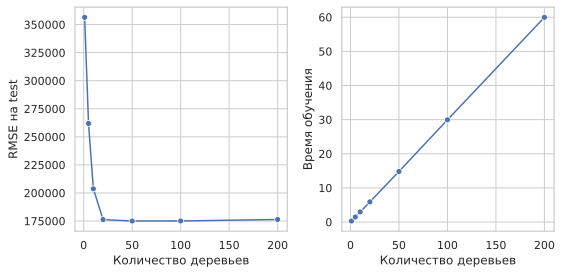

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(data=results, x='n_estimators', y='rmse_test', ax=ax[0], marker='o')
sns.lineplot(data=results, x='n_estimators', y='fit_time', ax=ax[1], marker='o')

ax[0].set_xlabel('Количество деревьев')
ax[1].set_xlabel('Количество деревьев')

ax[0].set_ylabel('RMSE на test')
ax[1].set_ylabel('Время обучения')

plt.tight_layout()

plt.savefig('gradient_boosting n_estimators.svg')
plt.show()

### Размерность подвыборки признаков для одной вершины дерева

In [32]:
n_estimators = 50
max_features_list = np.linspace(0.1, 1, 10)

results1 = pd.DataFrame({
    'max_features': [],
    'rmse_test': [],
    'fit_time': []
})

for max_features in tqdm.tqdm(max_features_list, desc="Training models"):
    model = GradientBoostingMSE(n_estimators=n_estimators, tree_params={'max_features': max_features})
    
    start_time = time.time()
    history = model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)

    results1.loc[len(results1)] = [max_features, root_mean_squared_error(y_pred, y_test), fit_time]
results1.sort_values(by='rmse_test')

Training models: 100%|███████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.62s/it]


,max_features,rmse_test,fit_time
2,0.3,132122.756685,5.109125
3,0.4,132956.550189,6.486597
4,0.5,134690.370687,7.870392
7,0.8,137735.026471,11.833351
5,0.6,138023.465369,9.139085
6,0.7,139572.510644,10.378446
1,0.2,141813.961461,3.660344
8,0.9,143666.716518,13.282954
0,0.1,145142.736311,2.366412
9,1.0,175225.382882,14.777317


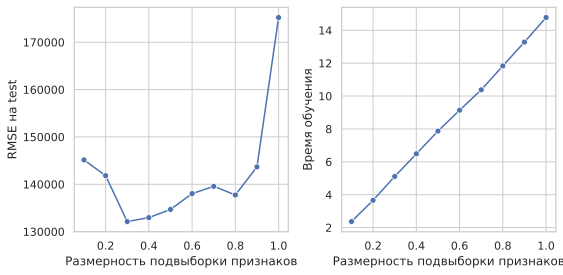

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(data=results1, x='max_features', y='rmse_test', ax=ax[0], marker='o')
sns.lineplot(data=results1, x='max_features', y='fit_time', ax=ax[1], marker='o')

ax[0].set_xlabel('Размерность подвыборки признаков')
ax[1].set_xlabel('Размерность подвыборки признаков')

ax[0].set_ylabel('RMSE на test')
ax[1].set_ylabel('Время обучения')

plt.tight_layout()

plt.savefig('gradient_boosting max_features.svg')
plt.show()

### Максимальная глубина дерева

In [34]:
n_estimators = 50
max_features = 0.3
max_depth_list = [x for x in range(1, 30, 3)] + [None]

results2 = pd.DataFrame({
    'max_depth': [],
    'rmse_test': [],
    'fit_time': []
})

for max_depth in tqdm.tqdm(max_depth_list, desc="Training models"):
    model = GradientBoostingMSE(n_estimators=n_estimators, tree_params={'max_features': max_features, 'max_depth': max_depth})
    
    start_time = time.time()
    history = model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)

    results2.loc[len(results2)] = [max_depth, root_mean_squared_error(y_pred, y_test), fit_time]
results2.sort_values(by='rmse_test')

Training models: 100%|███████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.47s/it]


,max_depth,rmse_test,fit_time
2,7.0,127659.018791,1.780249
4,13.0,131171.333428,3.220452
3,10.0,131837.383467,2.505856
8,25.0,132201.317303,4.901829
5,16.0,133986.948195,3.885631
10,NaN,134833.116039,5.006182
9,28.0,136584.722092,5.018729
7,22.0,136823.837017,4.747020
1,4.0,138000.317360,1.126299
6,19.0,139579.964358,4.482694


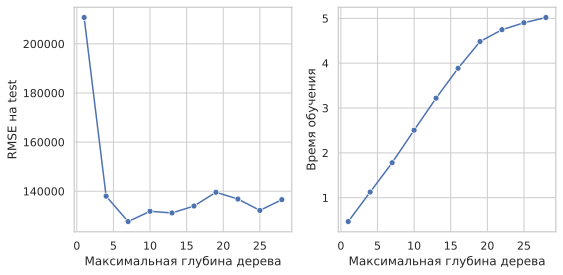

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(data=results2, x='max_depth', y='rmse_test', ax=ax[0], marker='o')
sns.lineplot(data=results2, x='max_depth', y='fit_time', ax=ax[1], marker='o')

ax[0].set_xlabel('Максимальная глубина дерева')
ax[1].set_xlabel('Максимальная глубина дерева')

ax[0].set_ylabel('RMSE на test')
ax[1].set_ylabel('Время обучения')

plt.tight_layout()

plt.savefig('gradient_boosting max_depth.svg')
plt.show()

In [37]:
results2.sort_values(by='rmse_test')

,max_depth,rmse_test,fit_time
2,7.0,127659.018791,1.780249
4,13.0,131171.333428,3.220452
3,10.0,131837.383467,2.505856
8,25.0,132201.317303,4.901829
5,16.0,133986.948195,3.885631
10,NaN,134833.116039,5.006182
9,28.0,136584.722092,5.018729
7,22.0,136823.837017,4.747020
1,4.0,138000.317360,1.126299
6,19.0,139579.964358,4.482694


### learning-rate

In [41]:
n_estimators = 50
max_features = 0.3
max_depth = 7
learning_rate_list = np.logspace(-3, 0, 10)

results3 = pd.DataFrame({
    'learning_rate': [],
    'rmse_test': [],
    'fit_time': []
})

for learning_rate in tqdm.tqdm(learning_rate_list, desc="Training models"):
    model = GradientBoostingMSE(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        tree_params={
            'max_features': max_features,
            'max_depth': max_depth,
        }
    )
    
    start_time = time.time()
    history = model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    y_pred = model.predict(X_test)

    results3.loc[len(results3)] = [learning_rate, root_mean_squared_error(y_pred, y_test), fit_time]
results3.sort_values(by='rmse_test')

Training models: 100%|███████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


,learning_rate,rmse_test,fit_time
6,0.100000,127649.331411,1.816896
7,0.215443,131480.396081,1.811749
5,0.046416,140270.389506,1.848335
8,0.464159,141902.727311,1.844396
4,0.021544,195708.041196,1.814846
9,1.000000,201917.334195,1.783404
3,0.010000,269321.530241,1.807228
2,0.004642,325307.329242,1.843702
1,0.002154,357826.865794,1.806252
0,0.001000,374080.876605,1.823010


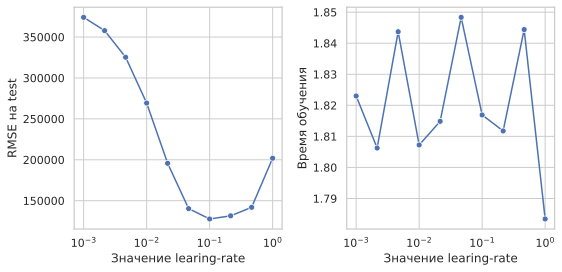

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(data=results3, x='learning_rate', y='rmse_test', ax=ax[0], marker='o')
sns.lineplot(data=results3, x='learning_rate', y='fit_time', ax=ax[1], marker='o')
ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_xlabel('Значение learing-rate')
ax[1].set_xlabel('Значение learing-rate')

ax[0].set_ylabel('RMSE на test')
ax[1].set_ylabel('Время обучения')

plt.tight_layout()

plt.savefig('gradient_boosting learning_rate.svg')
plt.show()

In [43]:
results3.sort_values(by='rmse_test')

,learning_rate,rmse_test,fit_time
6,0.100000,127649.331411,1.816896
7,0.215443,131480.396081,1.811749
5,0.046416,140270.389506,1.848335
8,0.464159,141902.727311,1.844396
4,0.021544,195708.041196,1.814846
9,1.000000,201917.334195,1.783404
3,0.010000,269321.530241,1.807228
2,0.004642,325307.329242,1.843702
1,0.002154,357826.865794,1.806252
0,0.001000,374080.876605,1.823010
